# Alpha Factors



## 1.1 Set up - importing everything and setting it all up for SPX500

In [16]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
idx = pd.IndexSlice

# Define start and end dates
start_date = datetime(2022, 1, 1)
end_date = datetime(2023, 12, 31)

# Fetch using yfinance
import yfinance as yf

# Fetch the list of S&P 500 companies along with their market capitalization
sp500_info = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500_info = sp500_info.rename(columns={'Symbol': 'Ticker'})

# Fetch market capitalization using yfinance
market_caps = {}
for ticker in sp500_info['Ticker']:
    try:
        stock_info = yf.Ticker(ticker)
        market_cap = stock_info.info['marketCap']
        market_caps[ticker] = market_cap
    except:
        print(f"Error fetching market cap for {ticker}")

# Convert market caps to DataFrame
market_caps_df = pd.DataFrame.from_dict(market_caps, orient='index', columns=['MarketCap'])
market_caps_df = market_caps_df.sort_values(by='MarketCap', ascending=False)

# Select the top 100 companies by market capitalization
top_symbols = market_caps_df.head(100).index

# Create a DataFrame to store monthly returns for the top 100 companies
top_returns = pd.DataFrame()

# Fetch and calculate returns for the top 100 S&P 500 companies
for stock_symbol in top_symbols:
    try:
        stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
        stock_prices = stock_data['Adj Close']
        monthly_returns = stock_prices.resample('M').ffill().pct_change().dropna() #code to resample to monthly returns
        top_returns[stock_symbol] = monthly_returns
    except:
        print(f"Error fetching data for {stock_symbol}")

# Print the returns for the top 100 companies
print(top_returns)


Error fetching market cap for BRK.B
Error fetching market cap for BF.B
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*****

In [17]:
top_returns.describe()
# Save the returns to a CSV file
top_returns.to_csv('raw_returns.csv', index=True)

# Print a message indicating the save operation
print("Calculated raw data saved to 'raw_returns.csv'")

Calculated raw data saved to 'raw_returns.csv'


In [18]:
# Calculate multiple historical returns with different lag periods

In [19]:
# Define outlier cutoff and lag periods
outlier_cutoff = 0.01
lags = [1, 2, 3, 6, 9, 12]

# Create a DataFrame to store calculated returns
calculated_returns = pd.DataFrame()

# Calculate returns for different lag periods
for lag in lags:
    returns = (top_returns
               .pct_change(lag)
               .stack()
               .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff), upper=x.quantile(1-outlier_cutoff)))
               .add(1)
               .pow(1/lag)
               .sub(1)
              )
    calculated_returns[f'return_{lag}m'] = returns

# Drop rows with NaN values
calculated_returns = calculated_returns.dropna()

# Display the calculated multiple historical returns
print(calculated_returns)
#In this code, after calculating the returns for different lag periods and storing them in calculated_returns, we use the .dropna() method to remove rows that contain any NaN values.
#This should help you eliminate rows with NaN values from your calculated returns DataFrame. Keep in mind that dropping rows with NaN values might result in reduced sample size for your analysis.

                 return_1m  return_2m  return_3m  return_6m  return_9m  \
Date                                                                     
2023-02-28 CRM   -1.097276  -0.612207   0.217245  -0.254835  -0.128207   
           INTU  -1.415807  -0.098257  -0.076780  -0.061010   0.152139   
           LMT   -1.632255   2.356755   1.123000   0.054518   0.021823   
           NOW   -1.292957  -0.134415   0.684570   0.110106   0.095307   
2023-03-31 CVS    1.082710   0.536600   0.090081   0.254658   0.112652   
2023-05-31 UNH   -1.238862   0.677584  -0.404091  -0.048862  -0.149721   
           MDT   -1.702787   1.238230   1.038244  -0.008934   0.068224   
2023-07-31 AAPL  -0.864460  -0.473129  -0.238793  -0.301963  -0.212330   
           COST  -0.210307   0.488211   0.479664  -0.162165  -0.046927   
           WFC    0.131007   1.954004   0.087465  -0.080763  -0.060849   
           GE    -0.502935   0.254882   0.049357  -0.250834  -0.185024   
2023-08-31 UNH   -1.528823   0.726589 

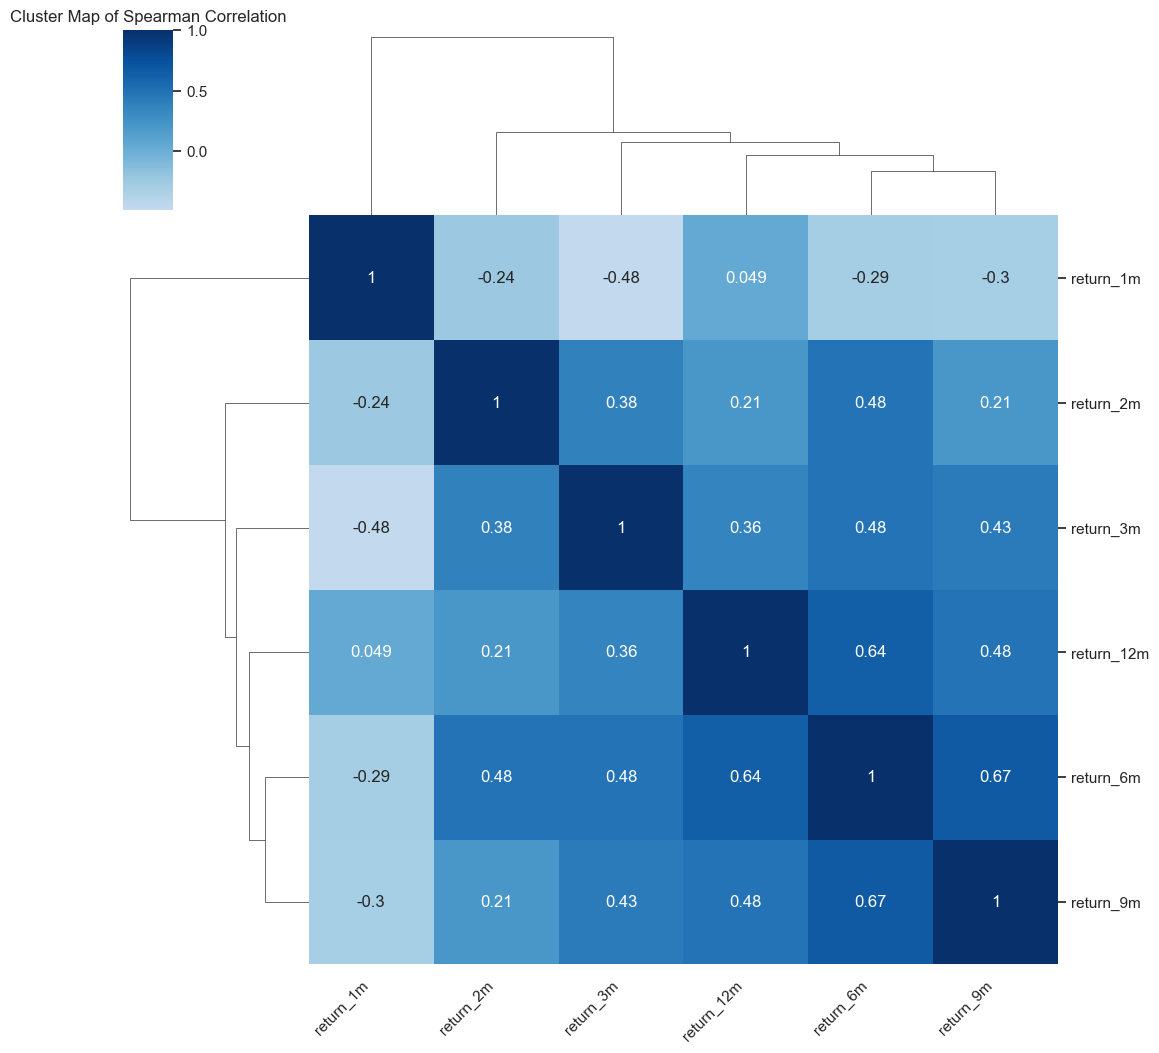

In [20]:
# Calculate the Spearman correlation matrix
correlation_matrix = data.corr('spearman')

# Create a cluster map
sns.set(rc={'figure.figsize':(10, 8)})
clustermap = sns.clustermap(correlation_matrix, annot=True, center=0, cmap='Blues')

# Adjust plot aesthetics
plt.setp(clustermap.ax_heatmap.get_xticklabels(), rotation=45, ha="right")
plt.setp(clustermap.ax_heatmap.get_yticklabels(), rotation=0)
plt.title("Cluster Map of Spearman Correlation")

# Show the plot
plt.show()

In [21]:
# Save the calculated historical returns to a CSV file
calculated_returns.to_csv('calculated_returns.csv', index=True)

# Print a message indicating the save operation
print("Calculated returns data saved to 'calculated_returns.csv'")

Calculated returns data saved to 'calculated_returns.csv'


## 1.2 Computing factor betas from the F-F model

In [65]:
import pandas as pd
import statsmodels.api as sm
import pandas_datareader.data as web

# Load the data from the CSV file
data = pd.read_csv('raw_returns.csv')

# Assuming 'Date' is a column in your DataFrame
data['Date'] = pd.to_datetime(data['Date'])

# Define the start and end dates for fetching factor data
start_date = data['Date'].min()
end_date = data['Date'].max()

In [66]:
import pandas_datareader.data as web

# Fetch Fama-French factor data
ff_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
ff_factors.index = ff_factors.index.to_timestamp()
ff_factors = ff_factors.resample('M').last().div(100)
ff_factors.index.name = 'date'

# Display the fetched Fama-French factor data
print(ff_factors.head())

            Mkt-RF     SMB     HML     RMW     CMA
date                                              
2000-01-31 -0.0474  0.0444 -0.0191 -0.0631  0.0475
2000-02-29  0.0245  0.1834 -0.0970 -0.1873 -0.0036
2000-03-31  0.0520 -0.1535  0.0817  0.1182 -0.0165
2000-04-30 -0.0640 -0.0501  0.0726  0.0766  0.0565
2000-05-31 -0.0442 -0.0384  0.0481  0.0417  0.0130


In [75]:
# Create an empty DataFrame to store factor betas
factor_betas_df = pd.DataFrame(columns=['Company', 'Beta (Market)', 'Beta (SMB)', 'Beta (HML)', 'Beta (RMW)', 'Beta (CMA)'])

# Merge the company returns and factor data on the 'Date' column
merged_data = pd.merge(data, ff_factors, left_on='Date', right_index=True)

# Loop through each company to calculate factor betas
for company in data.columns[1:]:  # Assuming the first column is 'Date'
    y = merged_data[company]
    X = sm.add_constant(merged_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])
    
    model = sm.OLS(y, X).fit()
    beta_market = model.params['Mkt-RF']
    beta_smb = model.params['SMB']
    beta_hml = model.params['HML']
    beta_rmw = model.params['RMW']
    beta_cma = model.params['CMA']
    
    # Append the calculated factor betas to the DataFrame
    factor_betas_df = factor_betas_df.append({
        'Company': company,
        'Beta (Market)': beta_market,
        'Beta (SMB)': beta_smb,
        'Beta (HML)': beta_hml,
        'Beta (RMW)': beta_rmw,
        'Beta (CMA)': beta_cma
    }, ignore_index=True)

# Display the DataFrame with calculated factor betas
print(factor_betas_df)


   Company  Beta (Market)  Beta (SMB)  Beta (HML)  Beta (RMW)  Beta (CMA)
0     AAPL       1.322157   -0.187293   -0.247741   -0.193150   -0.303718
1     MSFT       0.881887   -1.056650   -0.485420    0.387972   -0.094688
2    GOOGL       1.077993   -0.983318   -0.551552   -0.487457   -0.250566
3     GOOG       1.091863   -0.905292   -0.668099   -0.465075   -0.123856
4     AMZN       1.571590   -0.675896    0.034051   -1.710636   -1.373675
..     ...            ...         ...         ...         ...         ...
95      CB       0.634321    0.982673   -0.282439   -0.128529    1.476973
96     SLB       1.639618    0.029143    1.874702   -1.040762    0.532563
97     BDX       0.569445    0.465047   -0.676224    0.327254    1.331656
98       C       1.177233    0.278960    1.348428    0.443072   -1.157708
99     PGR       0.561591   -0.110039    0.500177   -0.608992    0.169564

[100 rows x 6 columns]


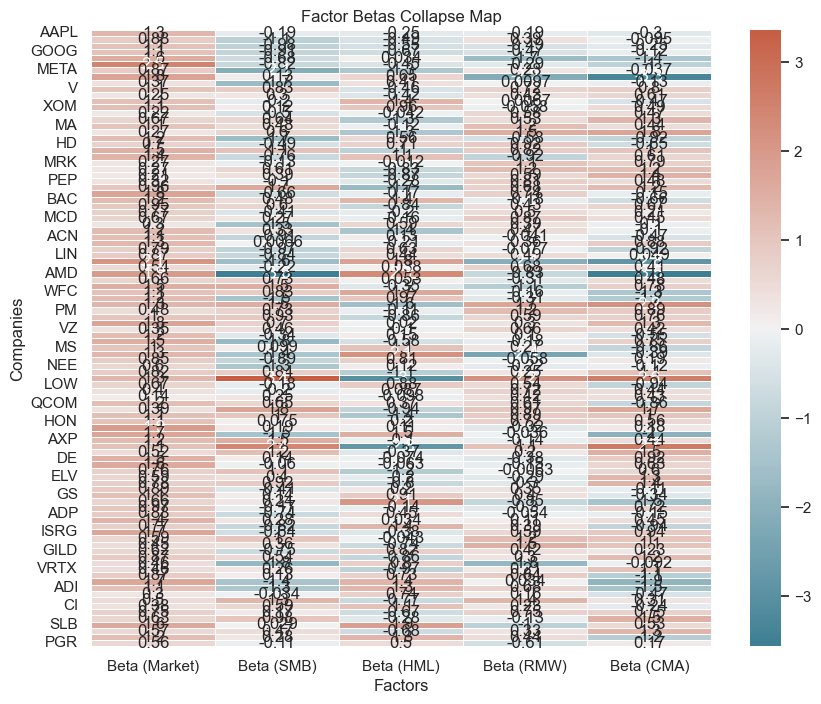

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the index of the factor betas DataFrame to 'Company'
factor_betas_df.set_index('Company', inplace=True)

# Create a custom colormap with three colors: positive, negative, and zero
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Create a heatmap using seaborn with the custom colormap
plt.figure(figsize=(10, 8))
sns.heatmap(factor_betas_df, annot=True, cmap=cmap, center=0, linewidths=0.5)

# Set the title and labels
plt.title("Factor Betas Collapse Map")
plt.xlabel("Factors")
plt.ylabel("Companies")

# Display the heatmap
plt.show()


## 1.3 - doing momentum factors

        Date Unnamed: 1  return_1m  return_2m  return_3m  return_6m  \
0 2023-02-28        CRM  -1.097276  -0.612207   0.217245  -0.254835   
1 2023-02-28       INTU  -1.415807  -0.098257  -0.076780  -0.061010   
2 2023-02-28        LMT  -1.632255   2.356755   1.123000   0.054518   
3 2023-02-28        NOW  -1.292957  -0.134415   0.684570   0.110106   
4 2023-03-31        CVS   1.082710   0.536600   0.090081   0.254658   

   return_9m  return_12m  
0  -0.128207   -0.102480  
1   0.152139   -0.108614  
2   0.021823   -0.110144  
3   0.095307    0.144342  
4   0.112652    0.137515  
        Date Unnamed: 1  return_1m  return_2m  return_3m  return_6m  \
0 2023-02-28        CRM  -1.097276  -0.612207   0.217245  -0.254835   
1 2023-02-28       INTU  -1.415807  -0.098257  -0.076780  -0.061010   
2 2023-02-28        LMT  -1.632255   2.356755   1.123000   0.054518   
3 2023-02-28        NOW  -1.292957  -0.134415   0.684570   0.110106   
4 2023-03-31        CVS   1.082710   0.536600   0.090081

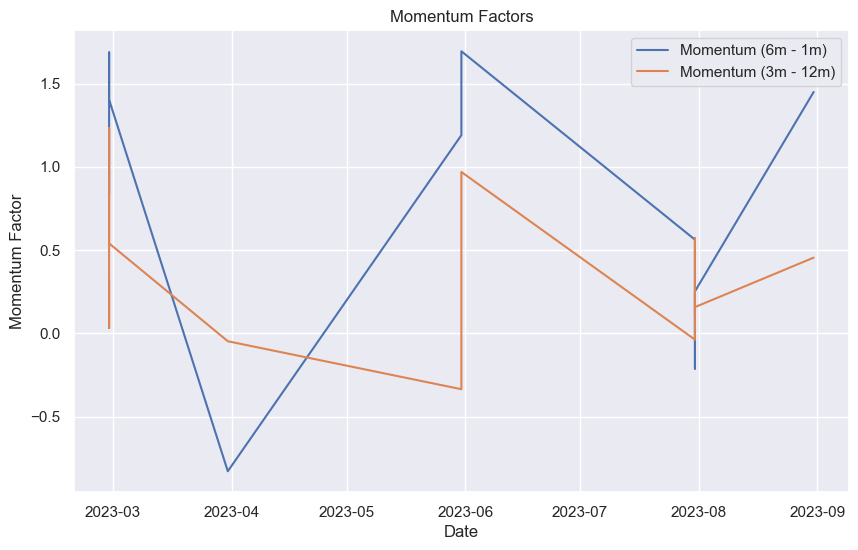

In [77]:
import pandas as pd

# Load the data from the CSV file
data = pd.read_csv('calculated_returns.csv')

# Convert the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Display the first few rows of the dataset
print(data.head())

# Calculate momentum factor based on the difference between returns over longer periods and the most recent monthly return
data['momentum_long'] = data['return_6m'] - data['return_1m']

# Calculate momentum factor based on the difference between 3 and 12 month returns
data['momentum_short'] = data['return_3m'] - data['return_12m']

# Display the updated dataset with momentum factors
print(data.head())


import matplotlib.pyplot as plt

# Plot the momentum factors
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['momentum_long'], label='Momentum (6m - 1m)')
plt.plot(data['Date'], data['momentum_short'], label='Momentum (3m - 12m)')
plt.xlabel('Date')
plt.ylabel('Momentum Factor')
plt.title('Momentum Factors')
plt.legend()
plt.grid(True)
plt.show()


